# Extract Review Labels

Extract `(abstract, study-id)` tuples.

In [1]:
df = pd.read_csv('pico_cdsr.csv')
df = df[['abstract', 'cdno', 'population', 'intervention', 'outcome']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46531 entries, 0 to 46530
Data columns (total 5 columns):
abstract        46531 non-null object
cdno            46531 non-null object
population      46531 non-null object
intervention    46531 non-null object
outcome         46531 non-null object
dtypes: object(5)
memory usage: 1.8+ MB


### Visualize `cdno` Distribution

In [2]:
cdnos = df.groupby('cdno')

len(cdnos)

4611

Most reviews have only a small number of studies...

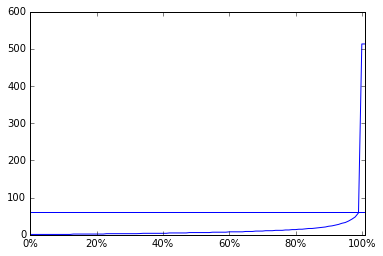

In [3]:
info = cdnos.size().describe(percentiles=np.linspace(start=0, stop=1, num=101))

axes = info['0%':].plot()
axes.axhline(y=60)

In [4]:
info

count    4611.000000
mean       10.091303
std        15.635355
min         1.000000
0%          1.000000
1%          1.000000
2%          1.000000
3%          1.000000
4%          1.000000
5%          1.000000
6%          1.000000
7.0%        1.000000
8%          1.000000
9%          1.000000
10%         1.000000
11%         1.000000
12%         1.000000
13%         2.000000
14.0%       2.000000
15%         2.000000
16%         2.000000
17%         2.000000
18%         2.000000
19%         2.000000
20%         2.000000
21%         2.000000
22%         2.000000
23%         3.000000
24%         3.000000
25%         3.000000
            ...     
72%        11.000000
73%        11.000000
74%        12.000000
75%        12.000000
76%        12.000000
77%        13.000000
78%        13.000000
79%        14.000000
80%        14.000000
81%        15.000000
82%        15.000000
83%        16.000000
84%        17.000000
85%        17.000000
86%        18.000000
87%        19.000000
88%        20

The number of studies greater than a certain number drops off exponentially...

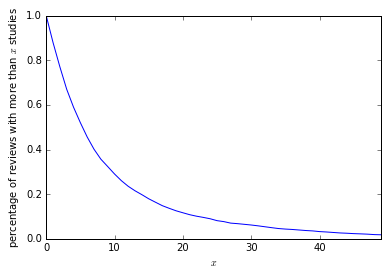

In [5]:
nb_review = len(cdnos)

s = pd.Series(len(cdnos.size()[cdnos.size() > i]) / float(len(cdnos)) for i in range(50))
s.name = 'foo'
s.index.name = '$x$'

axes = s.plot()
plt.ylabel('percentage of reviews with more than $x$ studies')

For the contrastive loss approach, we don't want to have too many reviews with a large number of studies because the assumption is that a randomly picked study will not be from the same review.

If there are 40,000 studies and the study with the maximum number of studies is 40, then the maximum probability of picking a study from the same review is $\frac{40}{40,000} = .1\%$ chance. For any other studies the probability is even lower, which I feel pretty good about.

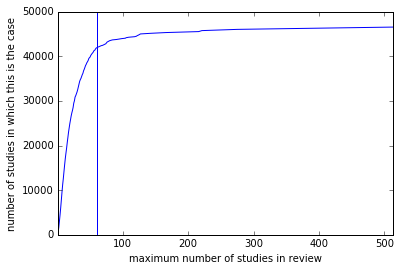

In [7]:
s = pd.Series(nb_study*nb_review for nb_study, nb_review in cdnos.size().value_counts().sort_index().iteritems())
s.index = cdnos.size().value_counts().sort_index().index

axes = s.cumsum().plot()
axes.axvline(x=60)

axes.set_xlabel('maximum number of studies in review')
axes.set_ylabel('number of studies in which this is the case')

Here's a good view of how many reviews there are having a certain amount of studies. We can see that reviews having at least 25 studies are usually in the single digits.

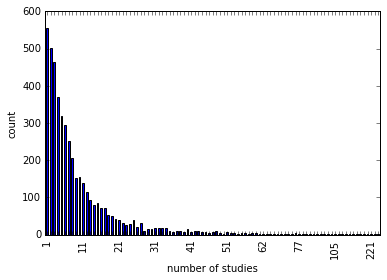

In [8]:
axes = cdnos.size().value_counts().sort_index().plot(kind='bar')

locs, labels = plt.xticks()

new_labels = ['']*len(labels)
for i in range(0, len(labels), 10):
    new_labels[i] = labels[i].get_text()
    
plt.xticks(locs, new_labels)
axes.set_xlabel('number of studies')
axes.set_ylabel('count')

Since 60 is the magic number, let's throw away all studies which are part of reviews of with more than 60 studies. This should leave us with 40,000+ studies.

In [9]:
cdno_set = set(cdnos.size()[cdnos.size() <= 60].index)

test_df = df[df.cdno.map(lambda cdno: cdno in cdno_set)].reset_index(drop=True)
test_df.to_csv('study_inclusion.csv')